# Building an monomial approximation of a function $$f(x):\mathbb{R}^d\rightarrow\mathbb{R}^q$$

## Environment setup

In [1]:
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed. 
# Only necessary when using notebook
%load_ext autoreload
%autoreload 2
from PyDakota.approximation import *

## Specifying the function variables $$x=(x_1,\ldots,x_d)\in \mathcal{X}\subseteq\mathbb{R}^d$$
Let us consider a function of two variables defined on the unit square, i.e. $\mathcal{X}=[0,1]^d$

In [2]:
num_vars = 2
variables = BoundedVariables()
ranges = define_homogeneous_ranges(num_vars, 0., 1.);
variables.set_ranges(ranges)

## Defining the function we want to approximate
Dakota provides a consistent interface to all functions and approximations. A standard python function can be wrapped using the PyFunction class. For example here we create a wrapper of the function $$f(x)=(f_1,f_2)^T,\quad f_j=\sum_{i=1}^d (jx_i^2+(j+1)x_i)+j$$

In [3]:
additive_quadratic_function = lambda x: numpy.sum(x**2)*numpy.arange(1,3) + numpy.sum(x)*numpy.arange(2,4) + numpy.arange(1,3)
function = PyFunction(additive_quadratic_function)

## Specifying the variable transformation $$T:\mathcal{X}\rightarrow \mathcal{U}$$
Often an approximation is not defined over the user defined variable space $\mathcal{X}$ but over another space $\mathcal{U}$. This is often done to enhance the numerical stability of the approximation or to facilitate the use of simpler approximations. For instance it usually best practice to convert a set of correlated Normal variables into a set of independent Normal variables using the tranformation $$T(x)=Lx$$ where $L$ is the Cholesky factor of the covariance of the correlated variables.

In this case the monomial approximation is always defined on $\mathcal{U}=[-1,1]^d$ so lets define a transformation $$T:[0,1]^d\rightarrow[-1,1]^d$$

In [4]:
var_transform = AffineVariableTransformation()
var_transform.set_variables(variables)

## Defining the approximation
Dakota supports many approximation methods. Here we focus on how to build a total-degree multivariate polynomial approximation
$$f(x)\approx p(T(x))=p(u)\sum_{\|\lambda\|_1\le 3} c_\lambda\phi_\lambda(u).$$ To define a 3rd order total degree monomial approximation run


In [5]:
from PyDakota.math_tools import compute_hyperbolic_indices
degree = 3
approx = Monomial()
approx.set_variable_transformation(var_transform)
basis_indices = compute_hyperbolic_indices(num_vars, degree, 1.)
approx.set_basis_indices(basis_indices)

## Building the approximation using least-squares
Dakota supports a number of methods to compute the polynomial coefficients. Here we will use least-squares. Specifically we evaluate the function at a set of samples $X=[x^{(1)},\ldots,x^{(M)}]$ to obtain a set of function values $Y=[f^{(1)},\ldots,f^{(M)}]^T$. The function may be vectored valued and thus each $f^{(i)}\in\mathbb{R}^Q$ is a vector and $Y\in\mathbb{R}^{M\times Q}$ is a matrix.

These function values can the be used to approximate the polynomial coefficients using least squares system $$\Phi c=Y,$$ where entries of the basis matrix $\Phi\in\mathbb{R}^{M\times N}$ are given by $\Phi_{ij}=\phi_j(x^{(i)})$. 

Here we will use QR factorization to solve the least squares problem.

In [6]:
from PyDakota.math_tools import qr_solve, NO_TRANS
num_build_samples = 2*basis_indices.shape[1]
build_samples = numpy.random.uniform(0,1,(num_vars,num_build_samples))
build_function_vals = function.value(build_samples)
basis_matrix = approx.generate_basis_matrix(build_samples)
coeffs = qr_solve(basis_matrix,build_function_vals,NO_TRANS)
approx.set_coefficients(coeffs)

## Taking advantage of Dakota approximation drivers
Dakota provides a number of algorithms for building approximation called drivers. These drivers essentially hide the details shown in the previous code block so that an approximation can just be built using

In [10]:
from PyDakota.approximation import QR_LSQ, regression_driver
opts = {'num_samples':2*basis_indices.shape[1], 'solver_type':QR_LSQ,'sample_type':'probabilistic_MC'}
result = regression_driver(function,approx,opts) # approx is modified in place
# result contains any data used to build the approx, some of which may be passed in through opts, also info about regression solve

## Interrogating the approximation 
Now we have built the approximation we can use it in replace of the true function. Here we show how to plot the approximation response surface.

Populating the interactive namespace from numpy and matplotlib


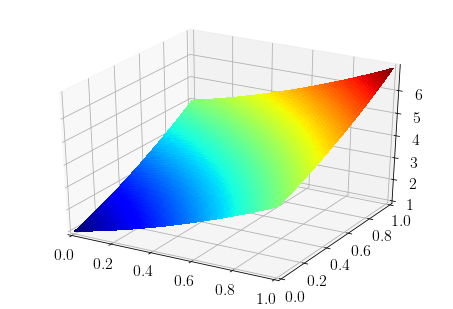

In [11]:
%pylab inline
from utilities.visualisation import plot_surface_from_function
plot_surface_from_function(approx.value,ranges)

## Unit testing
The following checks that the approximation behaves as desired. This code does not need to be run by the user, but is intended to aid automated testing of this notebook

In [13]:
num_test_samples = 100
test_samples = numpy.random.uniform(0,1,(num_vars,num_test_samples))
test_function_vals = function.value(test_samples)
approx_vals = approx.value(test_samples)
assert numpy.allclose(approx_vals,test_function_vals)